# Imports

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.metrics import mean_squared_error, accuracy_score
from IPython.display import display
import random as rd

# Part 1: Optimization

## Import the datasets

In [6]:
def preprocess(file):
    df = pd.read_csv(file)
    labels = df['Outcome'].to_numpy()
    data = normalize(df.drop(['Outcome'], axis=1).to_numpy())
    return data, labels

training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
test_data, test_labels = preprocess("diabetes_test.csv")

## Logistic Regression Implementation

In [7]:
logistic = lambda z: 1./ (1 + np.exp(-z))

def gradient(self, x, y):
    N = x.shape[0]
    yh = logistic(np.dot(x, self.w))    # predictions size N
    grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
    return grad                         # size D

def cost_fn(x, y, w):
    N, D = x.shape                                                       
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

class LogisticRegression:
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose

    def fit(self, x, y,valx,valy):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
            N2 = valx.shape[0]
            valx = np.column_stack([valx, np.ones(N2)])
        N,D = x.shape
        costs = []
        costval = []
        self.w = np.zeros(D)
        costs.append(cost_fn(x, y, self.w))
        g = np.inf
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g
            costs.append(cost_fn(x, y, self.w))
            costval.append(cost_fn(valx,valy,self.w))
            t += 1
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        # return self
        return t < self.max_iters, t, costs, costval

    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh
    def minibatch(self, x, y, size, valx, valy):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]  # num of instances
            x = np.column_stack([x, np.ones(N)])
            N2 = valx.shape[0]
            valx = np.column_stack([valx, np.ones(N2)])
        N, D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0  # start here
        y = np.expand_dims(y, axis=1)
        z = np.append(x, y, axis=1)
        pltx = []
        plty = []
        pltvaly = []
        best_t = 0
        best_cost = 1000
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            np.random.shuffle(z)
            size_start = 0
            size_end = size
            while (size_end <= N):
                z_num_size = z[size_start:size_end, ]
                y1 = z_num_size[:, -1:]
                x1 = z_num_size[:, :-1]
                y1 = y1.squeeze()
                g = self.gradient(x1, y1)
                self.w = self.w - self.learning_rate * g
                size_start = size_end
                size_end = size_end + size
            pltx.append(t)
            y2 = y.squeeze()
            cost = cost_fn(x, y2, self.w)
            costval = cost_fn(valx, valy, self.w)
            if (costval < best_cost):
                best_cost = costval
                best_t = t
            plty.append(cost)
            pltvaly.append(costval)
            t += 1  # num of epoach
            # self.learning_rate = self.learning_rate * (t ** -0.01)
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return pltx, plty, pltvaly, best_t, best_cost
    
    def fit_momentum(self, x, y, mmt,valx,valy):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]  # num of instances
            x = np.column_stack([x, np.ones(N)])
            N2 = valx.shape[0]
            valx = np.column_stack([valx, np.ones(N2)])
        N, D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0  # start here
        pltx = []
        plty = []
        pltvaly = []
        best_t = 0
        best_cost = 1000
        change = 0.0
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            # calculate the new change
            new_change = (1-mmt) * g + mmt * change
            # take a step
            self.w = self.w - self.learning_rate * new_change
            # update hte change
            change = new_change
            pltx.append(t)
            cost = cost_fn(x, y, self.w)
            costval = cost_fn(valx, valy, self.w)
            if (costval < best_cost):
                best_cost = costval
                best_t = t
            plty.append(cost)
            pltvaly.append(costval)
            t += 1
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        # return self
        # print('change : {} => {}'.format(a,b))
        return pltx, plty, pltvaly, best_t, best_cost
    
    def minibatch_momentum(self, x, y, size,mmt,valx, valy):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]  # num of instances
            x = np.column_stack([x, np.ones(N)])
            N2 = valx.shape[0]
            valx = np.column_stack([valx, np.ones(N2)])
        N, D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0  # start here
        y = np.expand_dims(y, axis=1)
        z = np.append(x, y, axis=1)
        pltx = []
        plty = []
        pltvaly = []
        best_t = 0
        best_cost = 1000
        change = 0.0
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            np.random.shuffle(z)
            size_start = 0
            size_end = size
            while (size_end <= N):
                z_num_size = z[size_start:size_end, ]
                y1 = z_num_size[:, -1:]
                x1 = z_num_size[:, :-1]
                y1 = y1.squeeze()
                g = self.gradient(x1, y1)
                new_change = (1 - mmt) * g + mmt * change
                # take a step
                self.w = self.w - self.learning_rate * new_change
                # update hte change
                change = new_change
                size_start = size_end
                size_end = size_end + size
            pltx.append(t)
            y2 = y.squeeze()
            cost = cost_fn(x, y2, self.w)
            costval = cost_fn(valx, valy, self.w)
            if (costval < best_cost):
                best_cost = costval
                best_t = t
            plty.append(cost)
            pltvaly.append(costval)
            t += 1  # num of epoach
            # self.learning_rate = self.learning_rate * (t ** -0.01)
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return pltx, plty, pltvaly, best_t, best_cost

LogisticRegression.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function

## 1.1 Plain Logistic Regression

### Experiments on various combinations of learning rate & max iterations

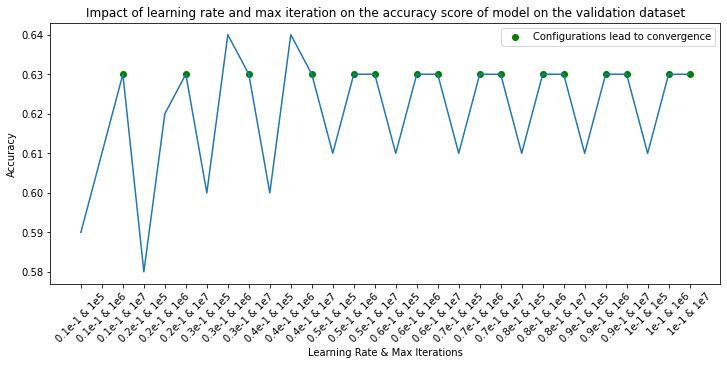

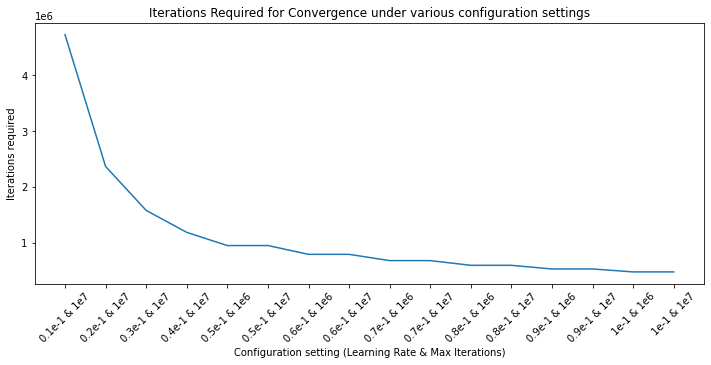

In [8]:
learning_rates = [0.1e-1, 0.2e-1, 0.3e-1, 0.4e-1, 0.5e-1, 0.6e-1, 0.7e-1, 0.8e-1, 0.9e-1, 1e-1]
max_values = [1e5, 1e6, 1e7]
accuracies = [0] * 30
#pointer: a counter to keep track of indices of learning_rates that leads to convergence
pointer = 0
#[convergent]: an array consisted of pointer count 
convergent = []
#[convergent_times]: an array consisted of values of 't', representing the value of iteration leads to convergence, 
#                    returned from fit() function.
convergent_times = []
for rate in learning_rates:
    for max_value in max_values:
        model = LogisticRegression(learning_rate=rate, max_iters=max_value, verbose=False)
        fit_result = model.fit(training_data, training_labels,validation_data, validation_labels)
        if fit_result[0]:
            # if t<max_iters, then report the value of iteration
            convergent.append(pointer)
            convergent_times.append(fit_result[1])
        # next test on the validation dataset to obtain the accuracy score of the model
        yh = model.predict(validation_data)
        prediction = [0 if i < 0.5 else 1 for i in yh]
        accuracies[pointer] = accuracy_score(validation_labels, prediction)
        pointer += 1
x_labels = [f'{i}e-1 & 1e{j}' for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] for j in [5, 6, 7]]

plt.figure(figsize=(12, 4.8))
convergent_accuracies = [accuracies[i] for i in convergent]
# plt.plot(np.arange(len(convergent)), convergent_accuracies)
plt.plot(np.arange(30), accuracies)
plt.scatter(convergent, convergent_accuracies, color='g', marker='o', label= 'Configurations lead to convergence')
# plt.scatter(convergent_accuracies.index(min(convergent_accuracies)), min(convergent_accuracies), color='g', marker='o', label=f'Min accuracies = {min(convergent_accuracies)}')
# plt.xlabel('Convergent Configurations (Learning Rate & Max Iterations)')
plt.xlabel('Learning Rate & Max Iterations')
# plt.xticks(np.arange(len(convergent)), [x_labels[i] for i in convergent], rotation=45)
plt.xticks(np.arange(30), x_labels, rotation=45)
plt.ylabel('Accuracy')
plt.title('Impact of learning rate and max iteration on the accuracy score of model on the validation dataset')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4.8))
plt.plot(np.arange(len(convergent_times)), convergent_times)
plt.xticks(np.arange(len(convergent_times)), [x_labels[i] for i in convergent], rotation=45)
plt.xlabel('Configuration setting (Learning Rate & Max Iterations)')
plt.ylabel('Iterations required')
plt.title('Iterations Required for Convergence under various configuration settings')
plt.show()




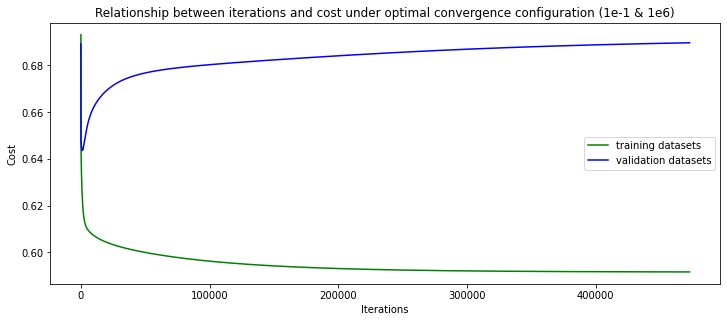

In [13]:
plt.figure(figsize=(12, 4.8))
optimal = LogisticRegression(learning_rate=1e-1, max_iters=1e6)
list1 = optimal.fit(training_data, training_labels,validation_data, validation_labels)
costs, runs, costs_val = list1[2], list1[1], list1[3]
runs_val = len(costs_val)
plt.plot(np.arange(runs + 1), costs, color='green', label='training datasets')
plt.plot(np.arange(runs_val), costs_val, color='blue', label='validation datasets')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Relationship between iterations and cost under optimal convergence configuration (1e-1 & 1e6)')
plt.show()

### Apply the model with optimal convergence configuration (1e-1 & 1e6) onto the test set

In [14]:
optimal = LogisticRegression(learning_rate=1e-1, max_iters=1e6)
optimal.fit(training_data, training_labels,validation_data, validation_labels)
yh = optimal.predict(test_data)
prediction = [0 if i < 0.5 else 1 for i in yh]
prediction_accuracy = accuracy_score(test_labels, prediction)
print(f'Prediction accuracy on the test dataset is: {prediction_accuracy}')

Prediction accuracy on the test dataset is: 0.6617647058823529


## 1.2: Logistic Regression with Mini-Batch Stochastic Gradient Descent

### Testing Training and Validation data on Various Batch Sizes

Batch size 1 with the default setting
The best validation cost is 0.6428012689549015 occuring at 2


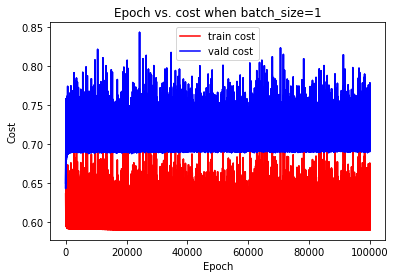

In [7]:
print("Batch size 1 with the default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_1,cost_1 = L1.minibatch(training_data,training_labels,1,validation_data,validation_labels)
print("The best validation cost is", cost_1,"occuring at",best_t_1)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost when batch_size=1")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

Batch size 6 with default setting
The best validation cost is 0.6438615197544638 occuring at 10


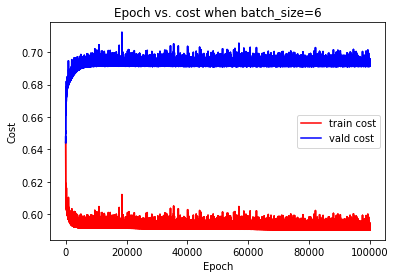

In [8]:
print("Batch size 6 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_6,cost_6 = L1.minibatch(training_data,training_labels,6,validation_data,validation_labels)
print("The best validation cost is", cost_6,"occuring at",best_t_6)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost when batch_size=6")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

Batch size 50 with default setting
The best validation cost is 0.6435955458442371 occuring at 90


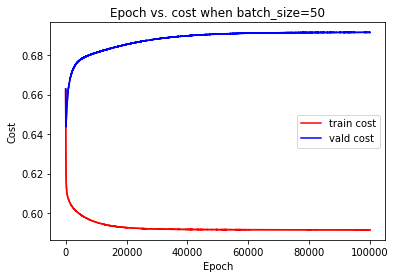

In [9]:
print("Batch size 50 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_50,cost_50 = L1.minibatch(training_data,training_labels,50,validation_data,validation_labels)
print("The best validation cost is", cost_50,"occuring at",best_t_50)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost when batch_size=50")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

Batch size 100 with default setting
The best validation cost is 0.6436100562323184 occuring at 195


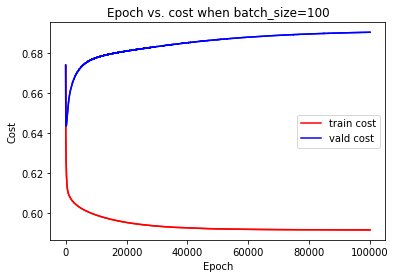

In [10]:
print("Batch size 100 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_100,cost_100 = L1.minibatch(training_data,training_labels,100,validation_data,validation_labels)
print("The best validation cost is", cost_100,"occuring at",best_t_100)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost when batch_size=100")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

Batch size 300 with default setting
The best validation cost is 0.6436110022780792 occuring at 561


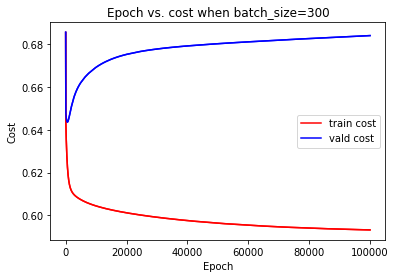

In [11]:
print("Batch size 300 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_300,cost_300 = L1.minibatch(training_data,training_labels,300,validation_data,validation_labels)
print("The best validation cost is", cost_300,"occuring at",best_t_300)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost when batch_size=300")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

Batch size 600 with default setting
The best validation cost is 0.6436122017483039 occuring at 1130


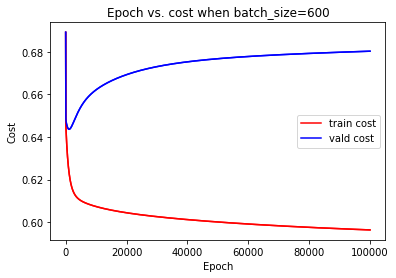

In [12]:
#this is batch size 600 aka full batch.
print("Batch size 600 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_600,cost_600 = L1.minibatch(training_data,training_labels,600,validation_data,validation_labels)
print("The best validation cost is", cost_600,"occuring at",best_t_600)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost when batch_size=600")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

### Apply the optimal t for validation dataset for each batch on test set. 
Note: Have to run previous code to run below cell (Above and Beyond)
### Implement the model with the optimal value of t (obtained from the validation datasets) to the test dataset with various batch sizes.

Appling best epoch on each batch size model


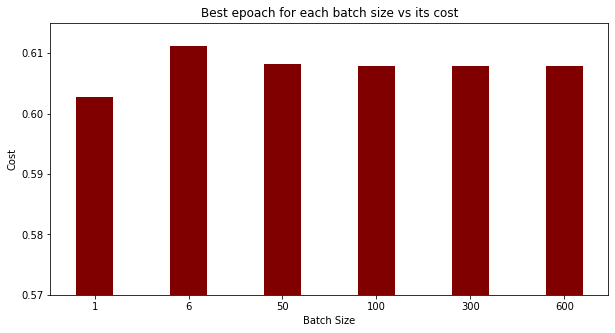

In [13]:
print("Appling best epoch on each batch size model")
test_data, test_labels = preprocess("diabetes_test.csv")
x = ["1","6","50","100","300","600"]
y = []
N = test_data.shape[0] #num of instances
test_data = np.column_stack([test_data, np.ones(N)])
L1 = LogisticRegression(True,.1,1e-4, best_t_1, verbose=False)
L1.minibatch(training_data,training_labels,1,validation_data,validation_labels)
cost1 = cost_fn(test_data,test_labels,L1.w)
y.append(cost1)
L2= LogisticRegression(True,.1,1e-4, best_t_6, verbose=False)
L2.minibatch(training_data,training_labels,6,validation_data,validation_labels)
cost2 = cost_fn(test_data,test_labels,L2.w)
y.append(cost2)
L3= LogisticRegression(True,.1,1e-4, best_t_50 ,verbose=False)
L3.minibatch(training_data,training_labels,50,validation_data,validation_labels)
cost3 = cost_fn(test_data,test_labels,L3.w)
y.append(cost3)
L4 = LogisticRegression(True,.1,1e-4, best_t_100 ,verbose=False)
L4.minibatch(training_data,training_labels,100,validation_data,validation_labels)
cost4 = cost_fn(test_data,test_labels,L4.w)
y.append(cost4)
L5 = LogisticRegression(True,.1,1e-4, best_t_300 ,verbose=False)
L5.minibatch(training_data,training_labels,300,validation_data,validation_labels)
cost5 = cost_fn(test_data,test_labels,L5.w)
y.append(cost5)
L6 = LogisticRegression(True,.1,1e-4, best_t_600,verbose=False)
L6.minibatch(training_data,training_labels,600,validation_data,validation_labels)
cost6 = cost_fn(test_data,test_labels,L6.w)
y.append(cost6)
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(x, y, color ='maroon',width = 0.4)
plt.ylim(0.57,0.615)
plt.xlabel("Batch Size")
plt.ylabel("Cost")
plt.title("Best epoach for each batch size vs its cost")
plt.show()

## 1.3 Logistic Regression with Momentum Gradient Descent

### Test Training and Validation data on Various Momentum coefficient (full batch)

Momentum coefficient 0.1 with default setting
The best validation cost is 0.6436122659848071 occuring at 1131


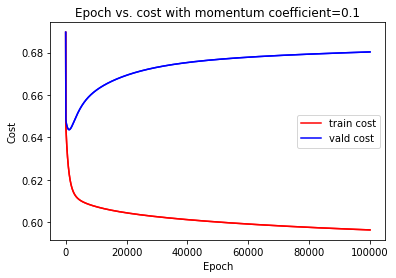

In [14]:
print("Momentum coefficient 0.1 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_1,cost_1 = L1.fit_momentum(training_data,training_labels,0.1,validation_data,validation_labels)
print("The best validation cost is", cost_1,"occuring at",best_t_1)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost with momentum coefficient=0.1")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

Momentum coefficient 0.3 with default setting
The best validation cost is 0.6436124484743823 occuring at 1131


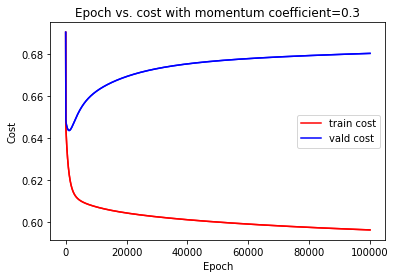

In [15]:
print("Momentum coefficient 0.3 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_3,cost_3 = L1.fit_momentum(training_data,training_labels,0.3,validation_data,validation_labels)
print("The best validation cost is", cost_3,"occuring at",best_t_3)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost with momentum coefficient=0.3")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

Momentum coefficient 0.5 with default setting
The best validation cost is 0.6436127787050939 occuring at 1131


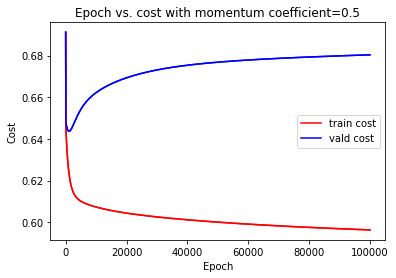

In [16]:
print("Momentum coefficient 0.5 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_5,cost_5 = L1.fit_momentum(training_data,training_labels,0.5,validation_data,validation_labels)
print("The best validation cost is", cost_5,"occuring at",best_t_5)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost with momentum coefficient=0.5")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

Momentum coefficient 0.7 with default setting
The best validation cost is 0.643613549042537 occuring at 1133


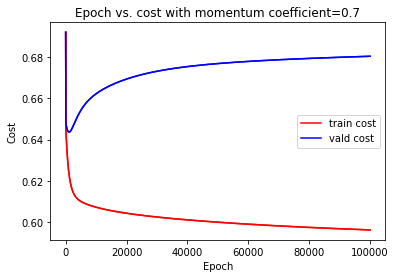

In [17]:
print("Momentum coefficient 0.7 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_7,cost_7 = L1.fit_momentum(training_data,training_labels,0.7,validation_data,validation_labels)
print("The best validation cost is", cost_7,"occuring at",best_t_7)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost with momentum coefficient=0.7")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

Momentum coefficient 0.9 with default setting
The best validation cost is 0.6436174274252187 occuring at 1140


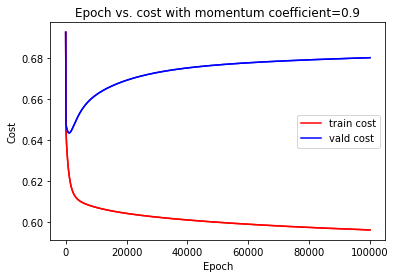

In [18]:
print("Momentum coefficient 0.9 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_9,cost_9 = L1.fit_momentum(training_data,training_labels,0.9,validation_data,validation_labels)
print("The best validation cost is", cost_9,"occuring at",best_t_9)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost with momentum coefficient=0.9")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

Momentum coefficient 0.999 with default setting
The best validation cost is 0.6457258152856954 occuring at 2245


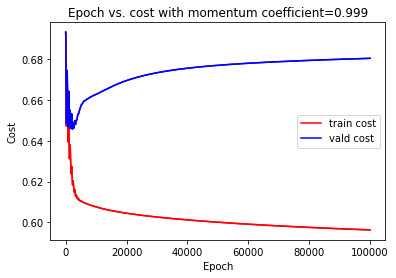

In [19]:
#since above does not really make a difference for exprimental purposes I decide to try a very big coefficient
print("Momentum coefficient 0.999 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_999,cost_999 = L1.fit_momentum(training_data,training_labels,0.999,validation_data,validation_labels)
print("The best validation cost is", cost_999,"occuring at",best_t_999)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost with momentum coefficient=0.999")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

The best validation cost is 0.6436174274252187 occuring at 1140


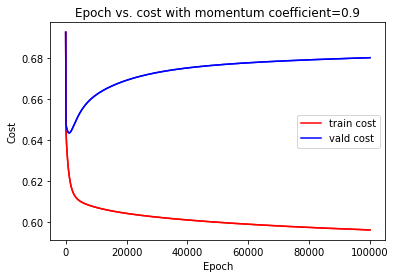

The best validation cost is 0.6436181503791321 occuring at 1141


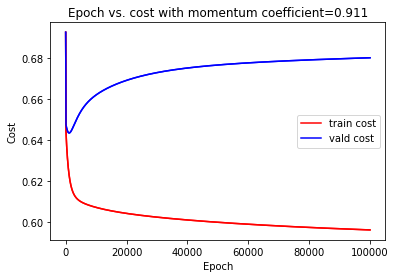

The best validation cost is 0.6436190798787219 occuring at 1143


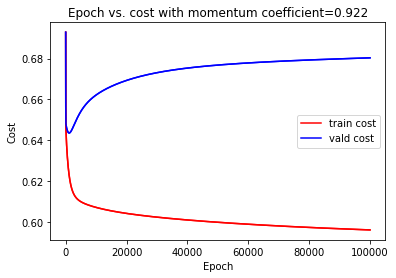

The best validation cost is 0.64362031688617 occuring at 1145


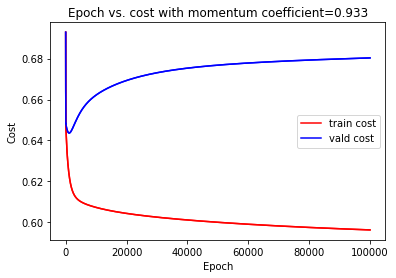

The best validation cost is 0.6436220461385544 occuring at 1148


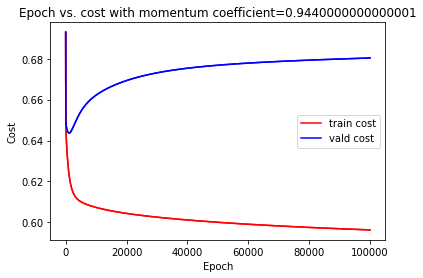

The best validation cost is 0.6436246338249751 occuring at 1153


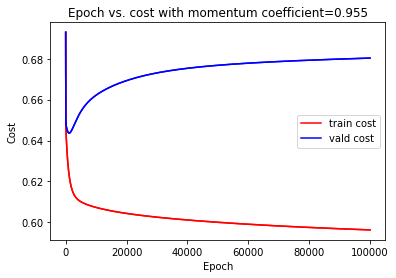

The best validation cost is 0.643628926370954 occuring at 1160


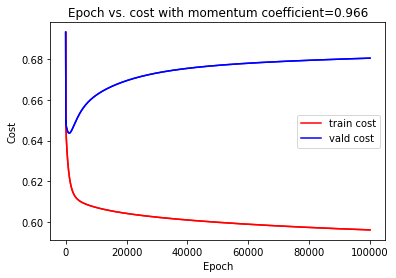

The best validation cost is 0.643637438509385 occuring at 1176


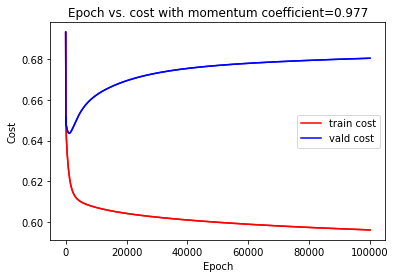

The best validation cost is 0.6436637954003674 occuring at 1229


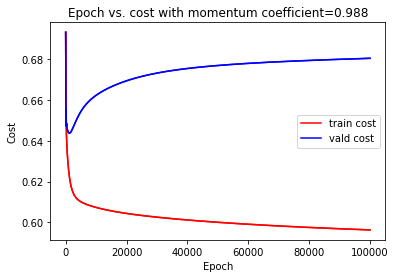

The best validation cost is 0.6457258152856954 occuring at 2245


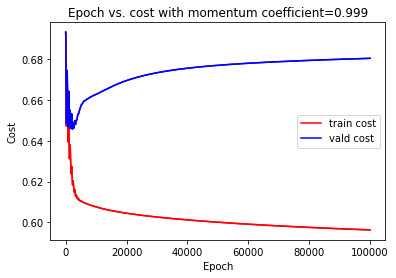

In [20]:
#just a few more between 0.9 and 0.999 not gonna be applied on the test case just to show the changing of the trend.
for mmt in np.linspace(0.9,0.999,10):
    L1 = LogisticRegression()
    x1,y1,z1,best_t,cost = L1.fit_momentum(training_data,training_labels,mmt,validation_data,validation_labels)
    print("The best validation cost is", cost,"occuring at",best_t)
    l1 = plt.plot(x1,y1,"r-",label = 'train cost')
    l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
    plt.plot(x1,y1,"r-")
    plt.plot(x1,z1,"b-")
    title = "Epoch vs. cost with momentum coefficient="+str(mmt)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Cost")
    plt.legend()
    plt.show()

### Apply the best t for validation data for each momentum coefficient on test set. Note: Have to run previous code to run below cell (Above and Beyond)

Appling best epoch on each batch size model
[0.6078119033651372, 0.6078121916484824, 0.6078127117592128, 0.6078115207143012, 0.6078092128391865, 0.6072824079970026]


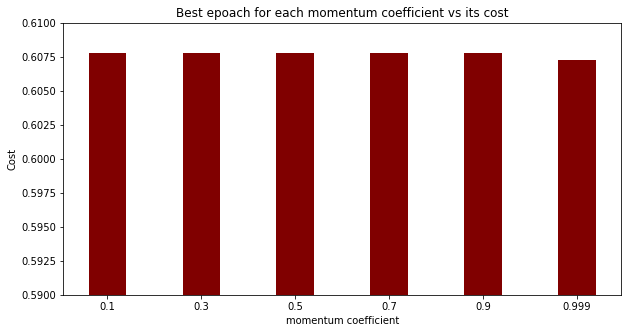

In [21]:
print("Appling best epoch on each batch size model")
test_data, test_labels = preprocess("diabetes_test.csv")
x = ["0.1","0.3","0.5","0.7","0.9","0.999"]
y = []
N = test_data.shape[0] #num of instances
test_data = np.column_stack([test_data, np.ones(N)])
L1 = LogisticRegression(True,.1,1e-4, best_t_1, verbose=False)
L1.fit_momentum(training_data,training_labels,0.1,validation_data,validation_labels)
cost1 = cost_fn(test_data,test_labels,L1.w)
y.append(cost1)
L2= LogisticRegression(True,.1,1e-4, best_t_3, verbose=False)
L2.fit_momentum(training_data,training_labels,0.3,validation_data,validation_labels)
cost2 = cost_fn(test_data,test_labels,L2.w)
y.append(cost2)
L3= LogisticRegression(True,.1,1e-4, best_t_5 ,verbose=False)
L3.fit_momentum(training_data,training_labels,0.5,validation_data,validation_labels)
cost3 = cost_fn(test_data,test_labels,L3.w)
y.append(cost3)
L4 = LogisticRegression(True,.1,1e-4, best_t_7 ,verbose=False)
L4.fit_momentum(training_data,training_labels,0.7,validation_data,validation_labels)
cost4 = cost_fn(test_data,test_labels,L4.w)
y.append(cost4)
L5 = LogisticRegression(True,.1,1e-4, best_t_9 ,verbose=False)
L5.fit_momentum(training_data,training_labels,0.9,validation_data,validation_labels)
cost5 = cost_fn(test_data,test_labels,L5.w)
y.append(cost5)
L6 = LogisticRegression(True,.1,1e-4, best_t_999,verbose=False)
L6.fit_momentum(training_data,training_labels,0.999,validation_data,validation_labels)
cost6 = cost_fn(test_data,test_labels,L6.w)
y.append(cost6)
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(x, y, color ='maroon',width = 0.4)
plt.xlabel("momentum coefficient")
plt.ylabel("Cost")
plt.ylim(0.59,0.61)
plt.title("Best epoach for each momentum coefficient vs its cost")
print(y)
plt.show()

## 1.4: Mini-Batch Gradient Descent implemented with Momentum 

### For Batch Size 6 with Various Momentum Coefficient 

We decide to use size 6 for our smallest minibatch size. Despite our smallest minibatch size in part 1.2 is 1. However, after looking at the graph for minibatch size 1. We think it is very messy and it would not give us a good general trend so we decide to start at the second smallest which is 6. Hoping it will give us a better general trend for us to analyze. 

Batch size 6,momentum and coefficient 0.1 with default setting
The best validation cost is 0.6437245193139879 occuring at 11


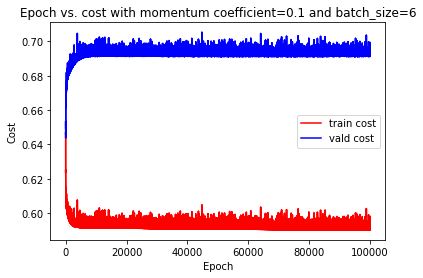

In [22]:
print("Batch size 6,momentum and coefficient 0.1 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_1,cost_1 = L1.minibatch_momentum(training_data,training_labels,6,0.1,validation_data,validation_labels)
print("The best validation cost is", cost_1,"occuring at",best_t_1)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost with momentum coefficient=0.1 and batch_size=6")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

Batch size 6,momentum and coefficient 0.3 with default setting
The best validation cost is 0.6439939356549782 occuring at 14


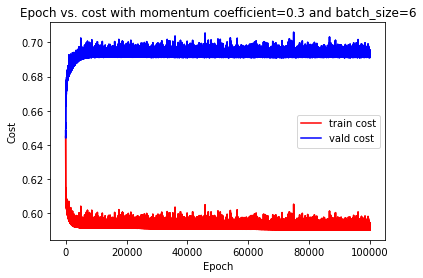

In [23]:
print("Batch size 6,momentum and coefficient 0.3 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_3,cost_3 = L1.minibatch_momentum(training_data,training_labels,6,0.3,validation_data,validation_labels)
print("The best validation cost is", cost_3,"occuring at",best_t_3)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost with momentum coefficient=0.3 and batch_size=6")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

Batch size 6,momentum and coefficient 0.5 with default setting
The best validation cost is 0.6439451088206805 occuring at 12


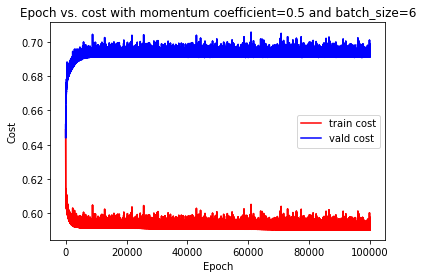

In [24]:
print("Batch size 6,momentum and coefficient 0.5 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_5,cost_5 = L1.minibatch_momentum(training_data,training_labels,6,0.5,validation_data,validation_labels)
print("The best validation cost is", cost_5,"occuring at",best_t_5)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost with momentum coefficient=0.5 and batch_size=6")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

Batch size 6,momentum and coefficient 0.7 with default setting
The best validation cost is 0.6435346564832741 occuring at 11


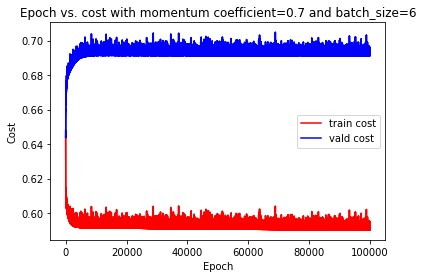

In [25]:
print("Batch size 6,momentum and coefficient 0.7 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_7,cost_7 = L1.minibatch_momentum(training_data,training_labels,6,0.7,validation_data,validation_labels)
print("The best validation cost is", cost_7,"occuring at",best_t_7)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost with momentum coefficient=0.7 and batch_size=6")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

Batch size 6,momentum and coefficient 0.9 with default setting
The best validation cost is 0.6438906120378802 occuring at 12


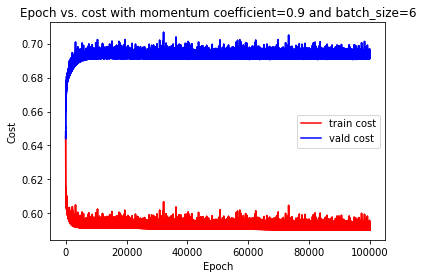

In [26]:
print("Batch size 6,momentum and coefficient 0.9 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_9,cost_9 = L1.minibatch_momentum(training_data,training_labels,6,0.9,validation_data,validation_labels)
print("The best validation cost is", cost_9,"occuring at",best_t_9)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost with momentum coefficient=0.9 and batch_size=6")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

The best validation cost is 0.6438157667765245 occuring at 14


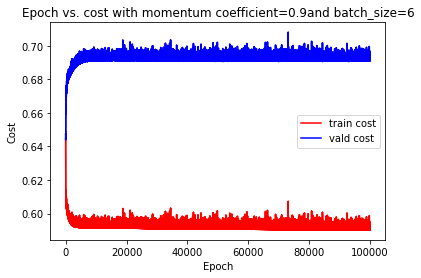

The best validation cost is 0.6437833807264025 occuring at 7


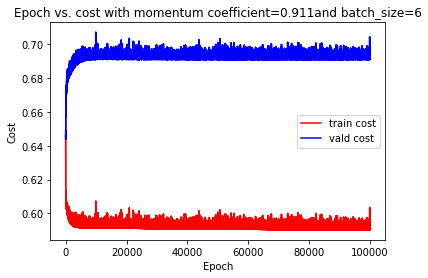

The best validation cost is 0.6436834276791076 occuring at 8


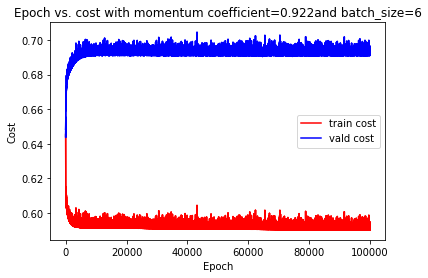

The best validation cost is 0.6434072839539554 occuring at 9


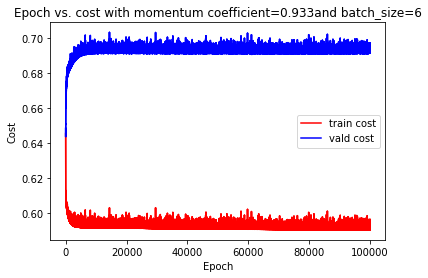

The best validation cost is 0.6435653373116452 occuring at 10


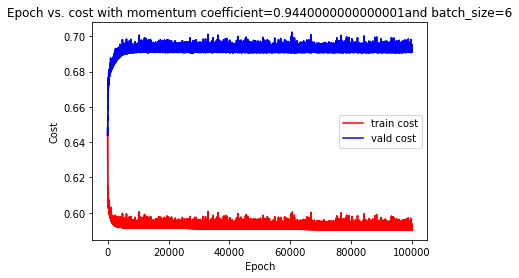

The best validation cost is 0.6432474366228728 occuring at 10


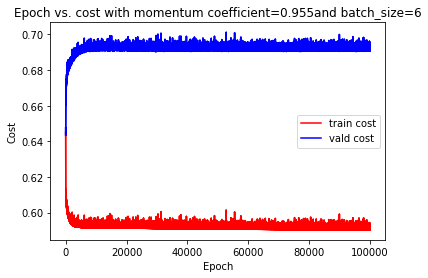

The best validation cost is 0.6434110772967186 occuring at 14


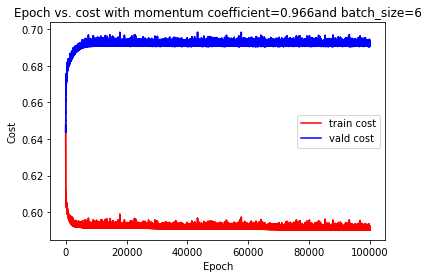

The best validation cost is 0.6432100390062445 occuring at 9


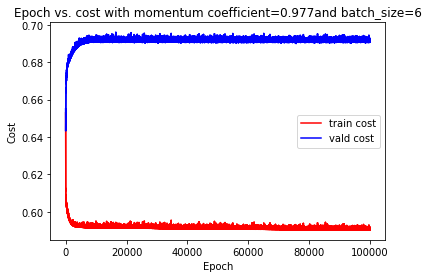

The best validation cost is 0.6436807167690972 occuring at 12


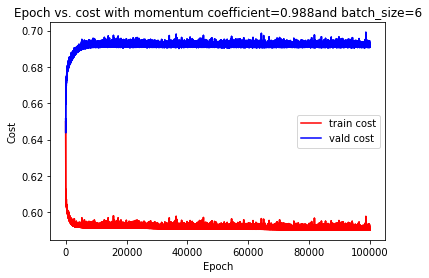

The best validation cost is 0.6461621198770867 occuring at 21


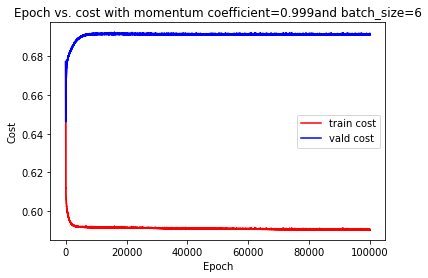

In [27]:
for mmt in np.linspace(0.9,0.999,10):
    L1 = LogisticRegression()
    x1,y1,z1,best_t,cost = L1.minibatch_momentum(training_data,training_labels,6,mmt,validation_data,validation_labels)
    print("The best validation cost is", cost,"occuring at",best_t)
    l1 = plt.plot(x1,y1,"r-",label = 'train cost')
    l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
    plt.plot(x1,y1,"r-")
    plt.plot(x1,z1,"b-")
    title = "Epoch vs. cost with momentum coefficient="+str(mmt)+"and batch_size=6"
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Cost")
    plt.legend()
    plt.show()

Batch size 6,momentum and coefficient 0.999 with default setting
The best validation cost is 0.6459307547573576 occuring at 22


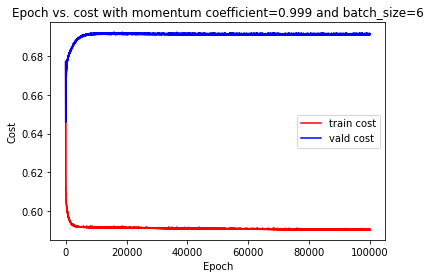

In [28]:
print("Batch size 6,momentum and coefficient 0.999 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_999,cost_999 = L1.minibatch_momentum(training_data,training_labels,6,0.999,validation_data,validation_labels)
print("The best validation cost is", cost_999,"occuring at",best_t_999)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost with momentum coefficient=0.999 and batch_size=6")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

### Apply the best t for validation data for each momentum coefficient on test set. Note: Have to run previous code to run below cell (Above and Beyond)

Appling best epoch on each batch size model
[0.6050643151936002, 0.6083215533408936, 0.6047911983152315, 0.6070095276595148, 0.60997045659226, 0.6121762822412586]


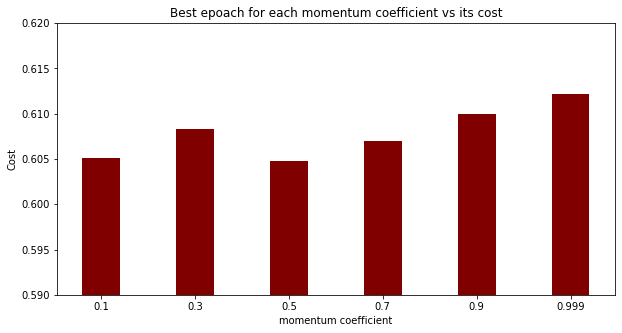

In [29]:
print("Appling best epoch on each batch size model")
test_data, test_labels = preprocess("diabetes_test.csv")
x = ["0.1","0.3","0.5","0.7","0.9","0.999"]
y = []
N = test_data.shape[0] #num of instances
test_data = np.column_stack([test_data, np.ones(N)])
L1 = LogisticRegression(True,.1,1e-4, best_t_1, verbose=False)
L1.minibatch_momentum(training_data,training_labels,6,0.1,validation_data,validation_labels)
cost1 = cost_fn(test_data,test_labels,L1.w)
y.append(cost1)
L2= LogisticRegression(True,.1,1e-4, best_t_3, verbose=False)
L2.minibatch_momentum(training_data,training_labels,6,0.3,validation_data,validation_labels)
cost2 = cost_fn(test_data,test_labels,L2.w)
y.append(cost2)
L3= LogisticRegression(True,.1,1e-4, best_t_5 ,verbose=False)
L3.minibatch_momentum(training_data,training_labels,6,0.5,validation_data,validation_labels)
cost3 = cost_fn(test_data,test_labels,L3.w)
y.append(cost3)
L4 = LogisticRegression(True,.1,1e-4, best_t_7 ,verbose=False)
L4.minibatch_momentum(training_data,training_labels,6,0.7,validation_data,validation_labels)
cost4 = cost_fn(test_data,test_labels,L4.w)
y.append(cost4)
L5 = LogisticRegression(True,.1,1e-4, best_t_9 ,verbose=False)
L5.minibatch_momentum(training_data,training_labels,6,0.9,validation_data,validation_labels)
cost5 = cost_fn(test_data,test_labels,L5.w)
y.append(cost5)
L6 = LogisticRegression(True,.1,1e-4, best_t_999,verbose=False)
L6.minibatch_momentum(training_data,training_labels,6,0.999,validation_data,validation_labels)
cost6 = cost_fn(test_data,test_labels,L6.w)
y.append(cost6)
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(x, y, color ='maroon',width = 0.4)
plt.xlabel("momentum coefficient")
plt.ylabel("Cost")
plt.ylim(0.59,0.62)
plt.title("Best epoach for each momentum coefficient vs its cost")
print(y)
plt.show()

### For Batch Size 300 with Various Momentum Coefficient

Full batch was run in previous set so we are going to run the second biggest batch size we ran earlier which is 300.

Batch size 300,momentum and coefficient 0.1 with default setting
The best validation cost is 0.6436110734973396 occuring at 570


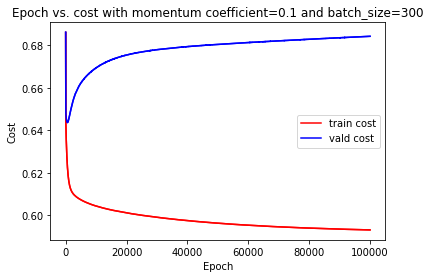

In [30]:
print("Batch size 300,momentum and coefficient 0.1 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_1,cost_1 = L1.minibatch_momentum(training_data,training_labels,300,0.1,validation_data,validation_labels)
print("The best validation cost is", cost_1,"occuring at",best_t_1)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost with momentum coefficient=0.1 and batch_size=300")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

Batch size 300,momentum and coefficient 0.3 with default setting
The best validation cost is 0.6436072047660791 occuring at 569


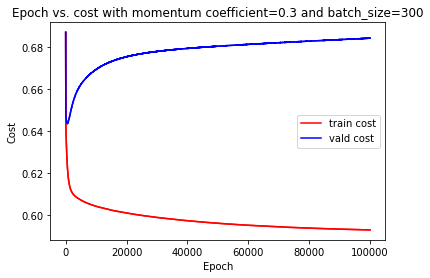

In [31]:
print("Batch size 300,momentum and coefficient 0.3 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_3,cost_3 = L1.minibatch_momentum(training_data,training_labels,300,0.3,validation_data,validation_labels)
print("The best validation cost is", cost_3,"occuring at",best_t_3)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost with momentum coefficient=0.3 and batch_size=300")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

Batch size 300,momentum and coefficient 0.5 with default setting
The best validation cost is 0.6435989833148397 occuring at 562


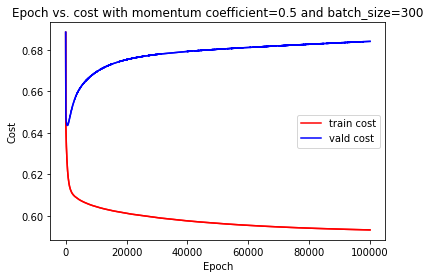

In [32]:
print("Batch size 300,momentum and coefficient 0.5 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_5,cost_5 = L1.minibatch_momentum(training_data,training_labels,300,0.5,validation_data,validation_labels)
print("The best validation cost is", cost_5,"occuring at",best_t_5)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost with momentum coefficient=0.5 and batch_size=300")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

Batch size 300,momentum and coefficient 0.7 with default setting
The best validation cost is 0.6436060863504228 occuring at 576


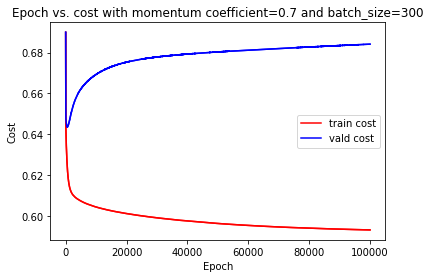

In [33]:
print("Batch size 300,momentum and coefficient 0.7 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_7,cost_7 = L1.minibatch_momentum(training_data,training_labels,300,0.7,validation_data,validation_labels)
print("The best validation cost is", cost_7,"occuring at",best_t_7)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost with momentum coefficient=0.7 and batch_size=300")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

Batch size 300,momentum and coefficient 0.9 with default setting
The best validation cost is 0.6436167035207616 occuring at 564


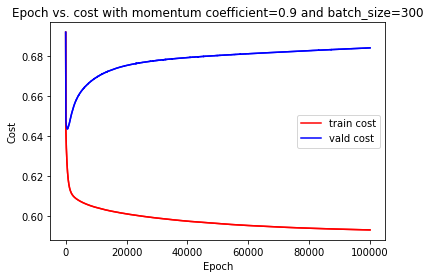

In [34]:
print("Batch size 300,momentum and coefficient 0.9 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_9,cost_9 = L1.minibatch_momentum(training_data,training_labels,300,0.9,validation_data,validation_labels)
print("The best validation cost is", cost_9,"occuring at",best_t_9)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost with momentum coefficient=0.9 and batch_size=300")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

The best validation cost is 0.6436113141016203 occuring at 585


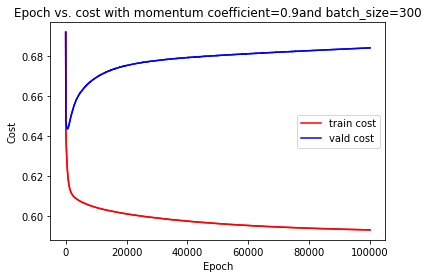

The best validation cost is 0.6436142403280717 occuring at 569


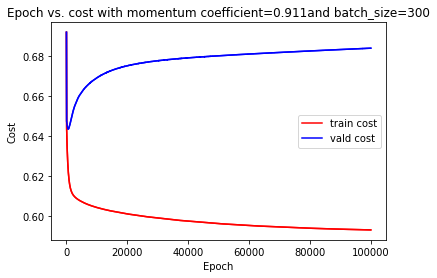

The best validation cost is 0.643618834327304 occuring at 556


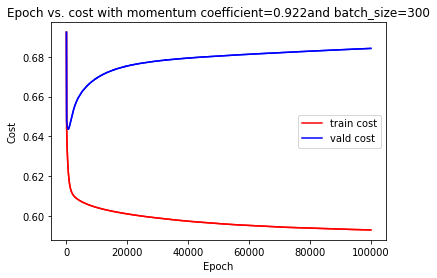

The best validation cost is 0.6436156206433217 occuring at 570


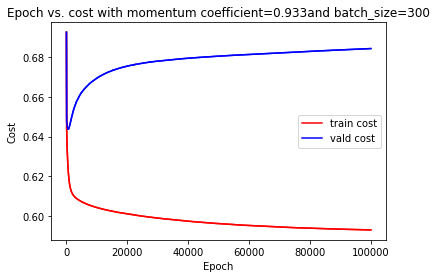

The best validation cost is 0.6436211073646985 occuring at 580


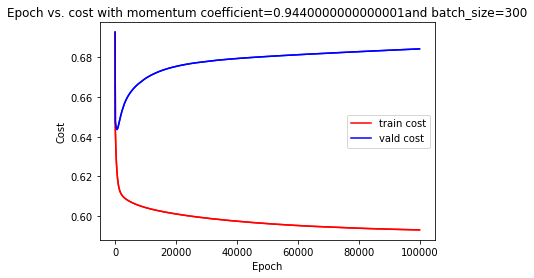

The best validation cost is 0.6436212712066265 occuring at 578


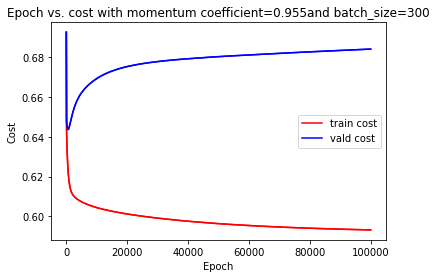

The best validation cost is 0.6436279233830016 occuring at 577


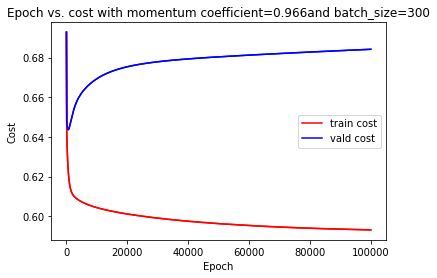

The best validation cost is 0.6436345174782413 occuring at 586


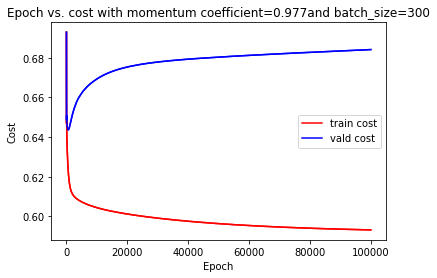

The best validation cost is 0.6436640712435611 occuring at 614


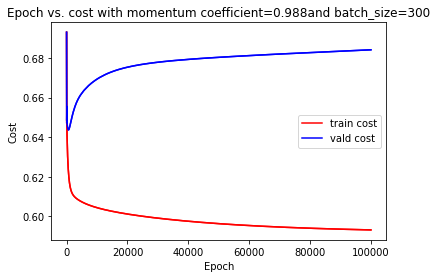

The best validation cost is 0.645725520125755 occuring at 1122


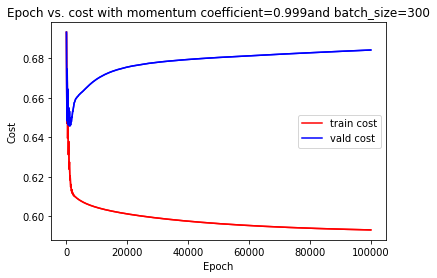

In [35]:
for mmt in np.linspace(0.9,0.999,10):
    L1 = LogisticRegression()
    x1,y1,z1,best_t,cost = L1.minibatch_momentum(training_data,training_labels,300,mmt,validation_data,validation_labels)
    print("The best validation cost is", cost,"occuring at",best_t)
    l1 = plt.plot(x1,y1,"r-",label = 'train cost')
    l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
    plt.plot(x1,y1,"r-")
    plt.plot(x1,z1,"b-")
    title = "Epoch vs. cost with momentum coefficient="+str(mmt)+"and batch_size=300"
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Cost")
    plt.legend()
    plt.show()

Batch size 300,momentum and coefficient 0.999 with default setting
The best validation cost is 0.645725548634326 occuring at 1122


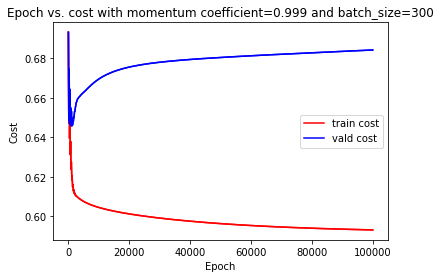

In [36]:
print("Batch size 300,momentum and coefficient 0.999 with default setting")
training_data, training_labels = preprocess("diabetes_train.csv")
validation_data, validation_labels = preprocess("diabetes_val.csv")
L1 = LogisticRegression()
x1,y1,z1,best_t_999,cost_999 = L1.minibatch_momentum(training_data,training_labels,300,0.999,validation_data,validation_labels)
print("The best validation cost is", cost_999,"occuring at",best_t_999)
l1 = plt.plot(x1,y1,"r-",label = 'train cost')
l2 = plt.plot(x1,z1,"b-",label = 'vald cost')
plt.plot(x1,y1,"r-")
plt.plot(x1,z1,"b-")
plt.title("Epoch vs. cost with momentum coefficient=0.999 and batch_size=300")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

### Apply the best t for validation data for each momentum coefficient on test set. Note: Have to run previous code to run below cell (Above and Beyond)

Appling best epoch on each batch size model
[0.6078040017017761, 0.6077975450117147, 0.6078778320389014, 0.607705575451056, 0.6077957774642497, 0.6073604451964447]


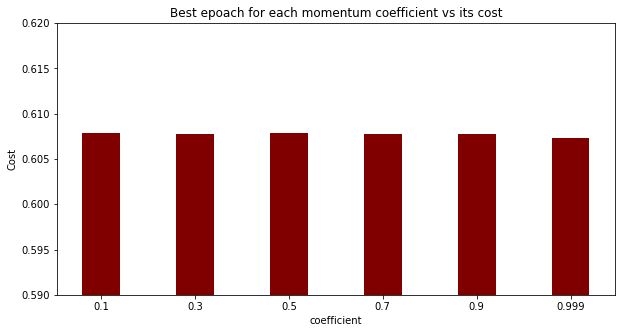

In [37]:
print("Appling best epoch on each batch size model")
test_data, test_labels = preprocess("diabetes_test.csv")
x = ["0.1","0.3","0.5","0.7","0.9","0.999"]
y = []
N = test_data.shape[0] #num of instances
test_data = np.column_stack([test_data, np.ones(N)])
L1 = LogisticRegression(True,.1,1e-4, best_t_1, verbose=False)
L1.minibatch_momentum(training_data,training_labels,300,0.1,validation_data,validation_labels)
cost1 = cost_fn(test_data,test_labels,L1.w)
y.append(cost1)
L2= LogisticRegression(True,.1,1e-4, best_t_3, verbose=False)
L2.minibatch_momentum(training_data,training_labels,300,0.3,validation_data,validation_labels)
cost2 = cost_fn(test_data,test_labels,L2.w)
y.append(cost2)
L3= LogisticRegression(True,.1,1e-4, best_t_5 ,verbose=False)
L3.minibatch_momentum(training_data,training_labels,300,0.5,validation_data,validation_labels)
cost3 = cost_fn(test_data,test_labels,L3.w)
y.append(cost3)
L4 = LogisticRegression(True,.1,1e-4, best_t_7 ,verbose=False)
L4.minibatch_momentum(training_data,training_labels,300,0.7,validation_data,validation_labels)
cost4 = cost_fn(test_data,test_labels,L4.w)
y.append(cost4)
L5 = LogisticRegression(True,.1,1e-4, best_t_9 ,verbose=False)
L5.minibatch_momentum(training_data,training_labels,300,0.9,validation_data,validation_labels)
cost5 = cost_fn(test_data,test_labels,L5.w)
y.append(cost5)
L6 = LogisticRegression(True,.1,1e-4, best_t_999,verbose=False)
L6.minibatch_momentum(training_data,training_labels,300,0.999,validation_data,validation_labels)
cost6 = cost_fn(test_data,test_labels,L6.w)
y.append(cost6)
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(x, y, color ='maroon',width = 0.4)
plt.xlabel("coefficient")
plt.ylabel("Cost")
plt.ylim(0.59,0.62)
plt.title("Best epoach for each momentum coefficient vs its cost")
print(y)
plt.show()

# Part 2: Text Classification

## Additional Imports

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
import re

## Test Different Configurations

### Keep Punctuations & (Unigram + Bigram) --- Best Performing Model

In [8]:
def tokenize(file):
    with open(file, mode='r', encoding='utf-8') as f:
        next(f)
        raw = f.read()
        # Use newline + " + , + (0 or 1) as an instance separator
        features = re.split('\n\",[0-1]', raw)[:-1]
        # First find all occurances of the aformentioned combination (which contains
        # the labels), then extract the labels from them
        labels = list(map(lambda x: int(x[-1]), re.findall('\n\",[0-1]', raw)))
        # Remove all punctuations and special characters
        # features = [(re.sub('[^a-zA-Z ]', '', i)).lower() for i in features]
        return features, labels

training_raw, training_labels = tokenize('fake_news_train.csv')
val_raw, val_labels = tokenize('fake_news_val.csv')
pipeline = make_pipeline(CountVectorizer(ngram_range=(1, 2), lowercase=False), TfidfTransformer(), LogisticRegressionCV(max_iter=1000))

# Make the prediction
pipeline.fit(training_raw, training_labels)
predicted = pipeline.predict(val_raw)
print(f'Text Classification Prediction Accuracy: {np.mean(predicted == val_labels)}')

Text Classification Prediction Accuracy: 0.7811704834605598


### Keep Punctuations & (Unigram Only)

In [9]:
def tokenize(file):
    with open(file, mode='r', encoding='utf-8') as f:
        next(f)
        raw = f.read()
        # Use newline + " + , + (0 or 1) as an instance separator
        features = re.split('\n\",[0-1]', raw)[:-1]
        # First find all occurances of the aformentioned combination (which contains
        # the labels), then extract the labels from them
        labels = list(map(lambda x: int(x[-1]), re.findall('\n\",[0-1]', raw)))
        # Remove all punctuations and special characters
        # features = [(re.sub('[^a-zA-Z ]', '', i)).lower() for i in features]
        return features, labels

training_raw, training_labels = tokenize('fake_news_train.csv')
val_raw, val_labels = tokenize('fake_news_val.csv')
pipeline = make_pipeline(CountVectorizer(ngram_range=(1, 1), lowercase=False), TfidfTransformer(), LogisticRegressionCV(max_iter=1000))

# Make the prediction
pipeline.fit(training_raw, training_labels)
predicted = pipeline.predict(val_raw)
print(f'Text Classification Prediction Accuracy: {np.mean(predicted == val_labels)}')

Text Classification Prediction Accuracy: 0.744529262086514


### Keep Punctuations & (Bigram Only)

In [10]:
def tokenize(file):
    with open(file, mode='r', encoding='utf-8') as f:
        next(f)
        raw = f.read()
        # Use newline + " + , + (0 or 1) as an instance separator
        features = re.split('\n\",[0-1]', raw)[:-1]
        # First find all occurances of the aformentioned combination (which contains
        # the labels), then extract the labels from them
        labels = list(map(lambda x: int(x[-1]), re.findall('\n\",[0-1]', raw)))
        # Remove all punctuations and special characters
        # features = [(re.sub('[^a-zA-Z ]', '', i)).lower() for i in features]
        return features, labels

training_raw, training_labels = tokenize('fake_news_train.csv')
val_raw, val_labels = tokenize('fake_news_val.csv')
pipeline = make_pipeline(CountVectorizer(ngram_range=(2, 2), lowercase=False), TfidfTransformer(), LogisticRegressionCV(max_iter=1000))

# Make the prediction
pipeline.fit(training_raw, training_labels)
predicted = pipeline.predict(val_raw)
print(f'Text Classification Prediction Accuracy: {np.mean(predicted == val_labels)}')

Text Classification Prediction Accuracy: 0.7470737913486005


### Remove Punctuations & (Unigram + Bigram)

In [11]:
def tokenize(file):
    with open(file, mode='r', encoding='utf-8') as f:
        next(f)
        raw = f.read()
        # Use newline + " + , + (0 or 1) as an instance separator
        features = re.split('\n\",[0-1]', raw)[:-1]
        # First find all occurances of the aformentioned combination (which contains
        # the labels), then extract the labels from them
        labels = list(map(lambda x: int(x[-1]), re.findall('\n\",[0-1]', raw)))
        # Remove all punctuations and special characters
        features = [(re.sub('[^a-zA-Z ]', '', i)).lower() for i in features]
        return features, labels

training_raw, training_labels = tokenize('fake_news_train.csv')
val_raw, val_labels = tokenize('fake_news_val.csv')
pipeline = make_pipeline(CountVectorizer(ngram_range=(1, 2)), TfidfTransformer(), LogisticRegressionCV(max_iter=1000))

# Make the prediction
pipeline.fit(training_raw, training_labels)
predicted = pipeline.predict(val_raw)
print(f'Text Classification Prediction Accuracy: {np.mean(predicted == val_labels)}')

Text Classification Prediction Accuracy: 0.7694656488549618


### Remove Puncuations + (Bigram Only)

In [12]:
def tokenize(file):
    with open(file, mode='r', encoding='utf-8') as f:
        next(f)
        raw = f.read()
        # Use newline + " + , + (0 or 1) as an instance separator
        features = re.split('\n\",[0-1]', raw)[:-1]
        # First find all occurances of the aformentioned combination (which contains
        # the labels), then extract the labels from them
        labels = list(map(lambda x: int(x[-1]), re.findall('\n\",[0-1]', raw)))
        # Remove all punctuations and special characters
        features = [(re.sub('[^a-zA-Z ]', '', i)).lower() for i in features]
        return features, labels

training_raw, training_labels = tokenize('fake_news_train.csv')
val_raw, val_labels = tokenize('fake_news_val.csv')
pipeline = make_pipeline(CountVectorizer(ngram_range=(2, 2)), TfidfTransformer(), LogisticRegressionCV(max_iter=1000))

# Make the prediction
pipeline.fit(training_raw, training_labels)
predicted = pipeline.predict(val_raw)
print(f'Text Classification Prediction Accuracy: {np.mean(predicted == val_labels)}')

Text Classification Prediction Accuracy: 0.7358778625954199


## Apply the best-performing model (keep punctuations & (unigram + bigram))onto the test set

In [ ]:
def tokenize(file):
    with open(file, mode='r', encoding='utf-8') as f:
        next(f)
        raw = f.read()
        # Use newline + " + , + (0 or 1) as an instance separator
        features = re.split('\n\",[0-1]', raw)[:-1]
        # First find all occurances of the aformentioned combination (which contains
        # the labels), then extract the labels from them
        labels = list(map(lambda x: int(x[-1]), re.findall('\n\",[0-1]', raw)))
        # Remove all punctuations and special characters
        # features = [(re.sub('[^a-zA-Z ]', '', i)).lower() for i in features]
        return features, labels

training_raw, training_labels = tokenize('fake_news_train.csv')
test_raw, test_labels = tokenize('fake_news_test.csv')
pipeline = make_pipeline(CountVectorizer(ngram_range=(1, 2), lowercase=False), TfidfTransformer(), LogisticRegressionCV(max_iter=1000))

# Make the prediction
pipeline.fit(training_raw, training_labels)
predicted = pipeline.predict(test_raw)
print(f'Text Classification Prediction Accuracy: {np.mean(predicted == test_labels)}')

Text Classification Prediction Accuracy: 0.7670299727520435
